# Transfer learning for classifying whatsapp data

In [41]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
from fastai import *
from fastai.text import *

In [43]:
import sklearn.feature_extraction.text as sklearn_text

Set path, batchsize, path etc. Arbitrary numbers copied from fastai notebook

In [44]:
path = Path('/users/rknol/Downloads/data_models/superawesome')

In [45]:
bs=128

In [46]:
lang = 'nl'

In [47]:
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

Load in data, including the wiki model that I trained in the NLWiki notebook

In [58]:
df = pd.read_csv(path/'cleaned.csv',sep=';')

In [59]:
data_lm = (TextList.from_df(df, path, cols='Message')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

In [60]:
data_clas = TextClasDataBunch.from_csv(path, 'cleaned.csv', vocab=data_lm.train_ds.vocab, bs=32, delimiter=';')

In [61]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

Training using the NLWiki model, this can also generate text

In [62]:
lr = 1e-2
lr *= bs/48 

In [63]:
learn_lm.fit_one_cycle(4, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.331580,4.454863,0.284226,08:49
1,5.029430,4.473028,0.303199,10:30
2,4.863323,4.328009,0.310491,11:35
3,4.673588,4.233962,0.315737,11:54


Now unfreezing and training some more

In [64]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(4, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.217105,3.985923,0.334598,34:26
1,4.058469,3.890374,0.344420,34:20
2,3.950065,3.840873,0.348251,34:41
3,3.854182,3.837336,0.349665,34:52


xxbos is start of line, data has a lot of short messages. The dutch sentences are reasonably grammatically correct, often include English video game phrases

In [69]:
learn_lm.predict("Wat", 30)

'Wat is me mee good xxbos bij de juiste collega xxbos We zijn om korea bezig bij ons nemen over Hoezo xxbos Roman is er nog een fitbit'

In [65]:
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

# CLASSIFIER

In [70]:
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='Message')
    .split_by_rand_pct(0.1, seed=40)
    .label_from_df(cols='Name')
    .databunch(bs=bs, num_workers=1))

data_clas.save(f'{lang}_textlist_class')

In [71]:
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

# Some stats on data, names are replaced

In [ ]:
data_clas.classes, data_clas.c, len(data_clas.train_ds), len(data_clas.valid_ds)

(['John', 'Ryan', 'Robert'], 3, 30902, 3433)

In [74]:
vc = pd.value_counts(data_clas.train_ds.y.items, sort=False)

In [ ]:
vc.index = data_clas.classes; vc

John 8593
Ryan 8902
Robert 13407
dtype: int64

In [39]:
vc = pd.value_counts(data_clas.valid_ds.y.items, sort=False)

In [ ]:
vc.index = data_clas.classes; vc

John 962
Ryan 1489
Robert 982
dtype: int64

In [76]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(f'{lang}fine_tuned_enc')
learn.freeze()

In [77]:
lr=2e-2
lr *= bs/48

In [79]:
learn.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.067057,1.057033,0.447131,07:09
1,1.034633,1.028434,0.480047,07:29


In [90]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.046712,1.021853,0.508302,07:53
1,1.000220,0.989714,0.520827,07:52


In [116]:
learn.freeze_to(-3)
learn.fit_one_cycle(10, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.895939,0.951183,0.549082,21:18
1,0.914137,1.024110,0.528401,21:16
2,0.884294,0.957475,0.557239,21:15
3,0.838583,1.084948,0.549665,21:14
4,0.775693,0.982157,0.560151,21:20
5,0.742951,1.026337,0.555200,21:00


In [98]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.885270,0.957263,0.543839,37:14


In [117]:
learn.save('whatsapp_full')

In [ ]:
learn.load('whatsapp_full')

I removed most of my analysis as to not include personal information

In [118]:
interp = ClassificationInterpretation.from_learner(learn)

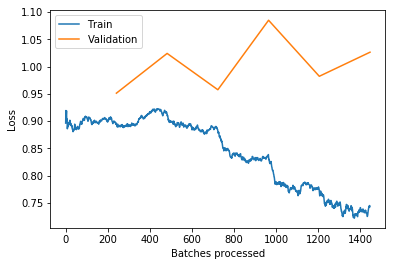

In [124]:
learn.recorder.plot_losses()

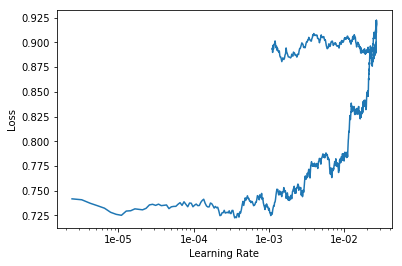

In [123]:
learn.recorder.plot()

In [ ]:
learn.predict("Ha jongens")